### Imports and set up

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#torch imports 
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset
from torcheeg.io.eeg_signal import EEGSignalIO
from torcheeg.models import DGCNN
from sklearn.metrics import accuracy_score
from torcheeg.models.gnn.dgcnn import GraphConvolution
# helper sctipts 
import utils.graph_utils as gu
import utils.data_utils as du
import utils.model_utils as mu 
import utils.visual_utils as vu
from utils.model_utils import TrainNN
from utils.cka import CKACalculator

# tracking 
import wandb

## Path constants
path="artifacts"
modelname="dgcnn_mod"
data_path = "../data/"
preprocessed_data_path = f"{path}/preprocessed_data.npy"
has_val_set = False
seed = 42

## Establish connection to datafile
IO = EEGSignalIO(io_path=str(data_path), io_mode='lmdb')
bands = {"delta": [1, 4],"theta": [4, 8],"alpha": [8, 14],"beta": [14, 31],"gamma": [31, 49]}

## Read metadata dataframeimports
metadata = pd.read_csv(data_path + 'sample_metadata.tsv', sep='\t')

In [2]:
# Verifying connection to data
idxs = np.arange(len(metadata))

# Read features and labels as torch tensors
X = torch.FloatTensor(np.array([IO.read_eeg(str(i)) for i in idxs]))
y = torch.tensor(metadata["value"].values, dtype=torch.long)

In [3]:
X_bde = du.band_preprocess(X, preprocessed_data_path)     

### Split data into train, validation and test sets

In [4]:
if has_val_set:
    X_train, y_train, X_val, y_val, X_test, y_test = du.split_data(X_bde, y, has_val_set=has_val_set, seed=seed)
    assert (X_train.shape[0]+X_val.shape[0]+X_test.shape[0])==X.shape[0], "Data samples lost in preprossesing"
    assert (y_train.shape[0]+y_val.shape[0]+y_test.shape[0])==X.shape[0], "Data samples lost in preprossesing"
    
    nsamples_val, nchannels_val, bands = X_val.shape
    val_dataset = TensorDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
    
else:
    X_train, y_train, X_test, y_test = du.split_data(X_bde, y, has_val_set=has_val_set, seed=seed)
    assert (X_train.shape[0]+X_test.shape[0])==X.shape[0], "Data samples lost in preprossesing"
    assert (y_train.shape[0]+y_test.shape[0])==X.shape[0], "Data samples lost in preprossesing"

assert X_train.shape[1]==X.shape[1],"Preprossed data lost channels"
assert X_train.shape[2]==len(bands),"Preprossed data does have incorrect amount of bands"

nsamples_train, nchannels_train, bands = X_train.shape
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

### Training & model hyperparameters

## Train model
### Train 4 models and calculate CKA matrices for pairs of models
## Functions to get activations of a layer type and calculated adjacency matrix

In [5]:
mods = []
wandb.login()
def train_models(model,modeltrainer,num_models=1,new =False, prints=False):
    """
    Training a model with random initialisation but consitent parameters. 
    
    Hyper parameters should be set outside of this function 
    
    path and model_names are both needed parameters that need to be defined outside of this function. 
    
    Path is to where your artifacts are located and model_name is what the model is called 
    
    ...
    
    Parameters
    -----------
    model : nn.modules
        The model being trained
    modeltrainer : training class
        a class for training the model provided should return a trained model
    num_models : int 
        Default 1, how many models it trains
    new : bool
        Weather it should attempt to use saved models
    """
    for i in range(num_models):
        
        tmp_mod = model(in_channels=num_chans, num_electrodes=num_electrodes, 
                              hid_channels=hid_chans, num_layers=num_layers, num_classes=num_outputs)
        model_path=f"{path}/{modelname}{i}.pth"
        print(f"Model {i+i}:")
        if new or not os.path.exists(model_path):    
            if not os.path.exists(model_path) and not new:
                print(f"Could not resolve path: {model_path}")
                new_models=True
            trainer = modeltrainer()
            
            if has_val_set:
                mods.append(trainer.train_model(tmp_mod, train_loader, learning_rate=lr,path=path,name=modelname,
                            has_val_set=has_val_set,val_loader=val_loader,w_decay=w_decay,epochs=epochs, 
                            prints=prints, modrun=i))
            else:
                mods.append(trainer.train_model(tmp_mod, train_loader, learning_rate=lr,path=path,name=modelname,
                                                has_val_set=has_val_set,val_loader=None,w_decay=w_decay,epochs=epochs, 
                                                prints=prints, modrun=i))   
        else: 
            tmp_mod.load_state_dict(torch.load(model_path))
            tmp_mod.eval()
            mods.append([tmp_mod,[]])

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: lili-raleva (braincells) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [7]:
# Model parameters
num_chans = 5
num_electrodes = 22
num_outputs = y.max().item() + 1
num_layers = 2
hid_chans = 16

# Training parameters
lr = 1e-4
epochs = 200
w_decay = 1e-3

#Models 
modruns = 4
plot=True
new_models=False
train_models(DGCNN, TrainNN, num_models=modruns, prints=plot, new=new_models)

Model 0:
Model 2:
Model 4:
Model 6:


Model 1 test
Acc train: 0.6341933928140825
Acc test: 0.46383799421407906
F1 train: 0.6337146154473664
F1 test: 0.4637440588859038


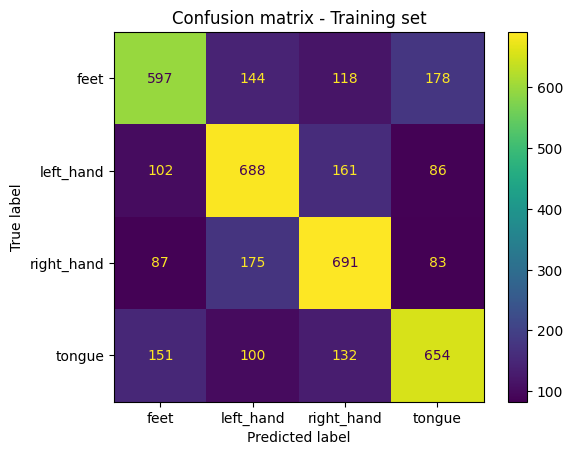

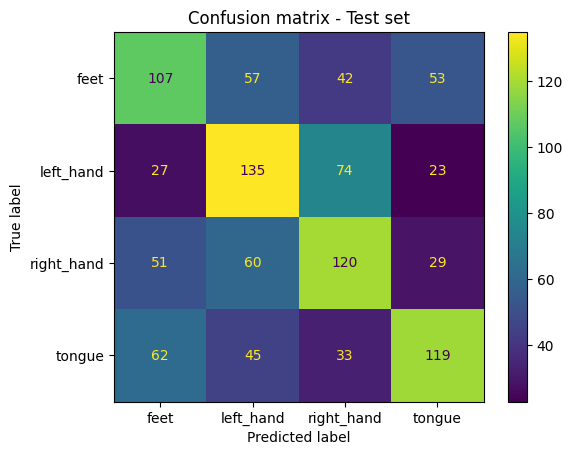

Model 2 test
Acc train: 0.6525198938992043
Acc test: 0.48987463837994216
F1 train: 0.652522632776843
F1 test: 0.4897385990794436


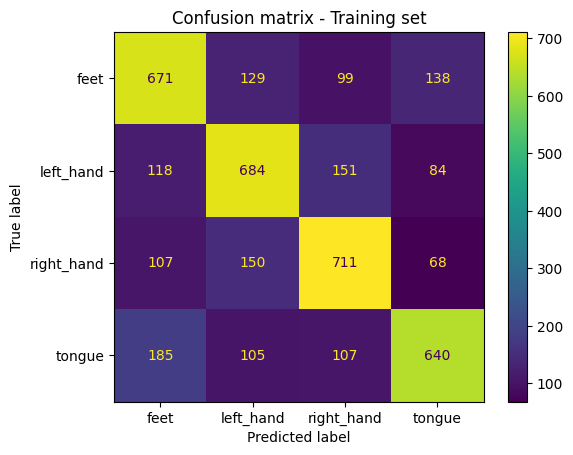

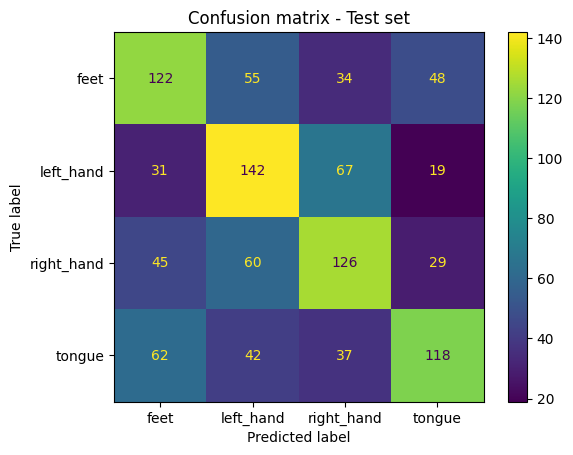

Model 3 test
Acc train: 0.6730166385338799
Acc test: 0.4840887174541948
F1 train: 0.671483597058967
F1 test: 0.4810626946386487


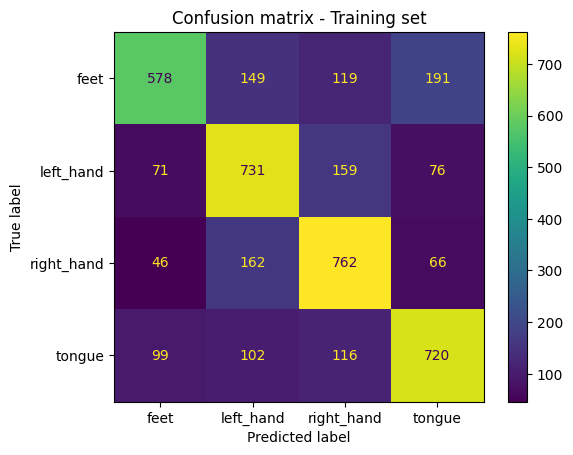

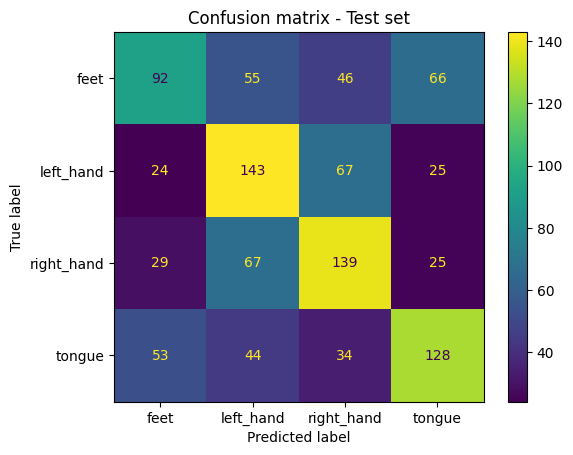

Model 4 test
Acc train: 0.6329877019532192
Acc test: 0.476374156219865
F1 train: 0.632030423468309
F1 test: 0.474548952803171


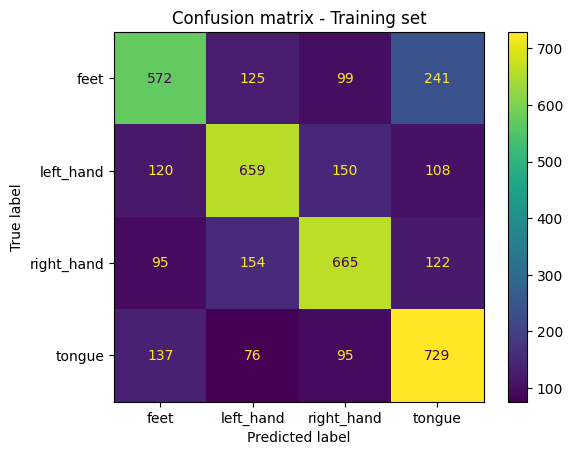

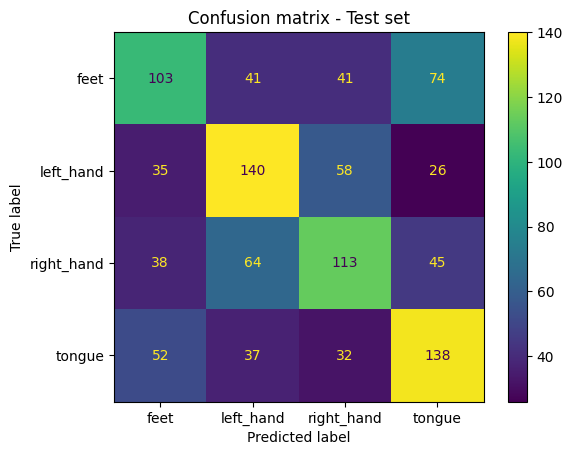

In [8]:
for i in range(modruns):
    print(f"Model {i+1} test")
    test_model = mods[i][0].to("cpu").eval()
    mu.model_metrics(test_model, X_train, y_train, X_test, y_test, None, None,plots=plot)

## Graphs


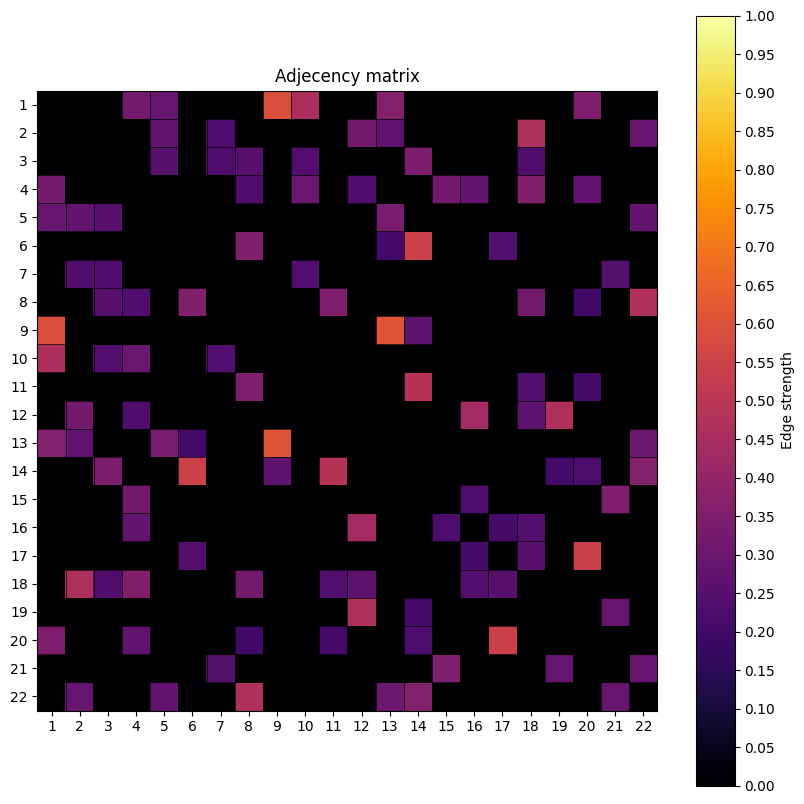

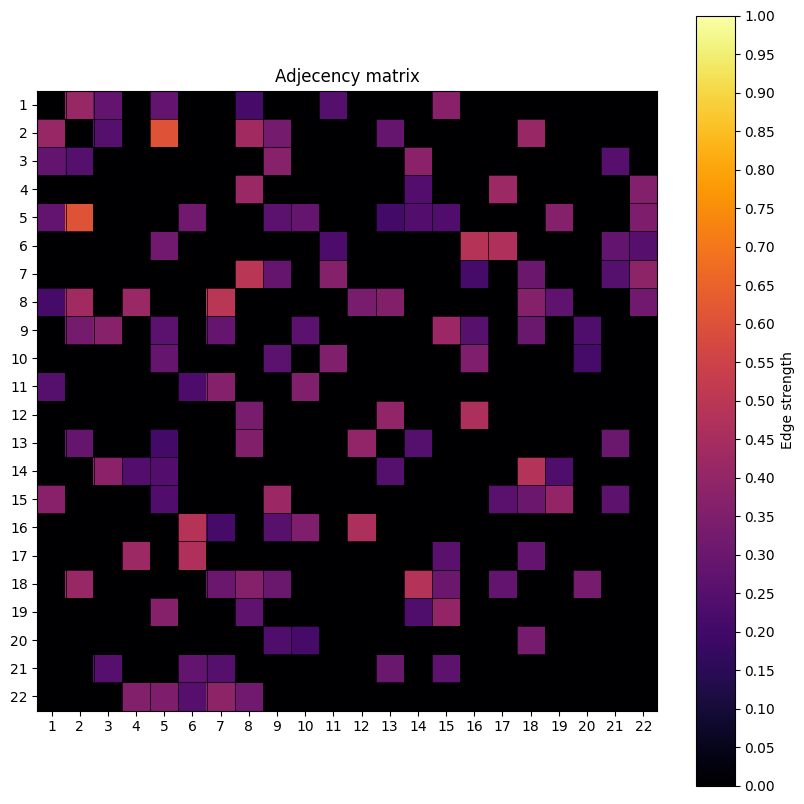

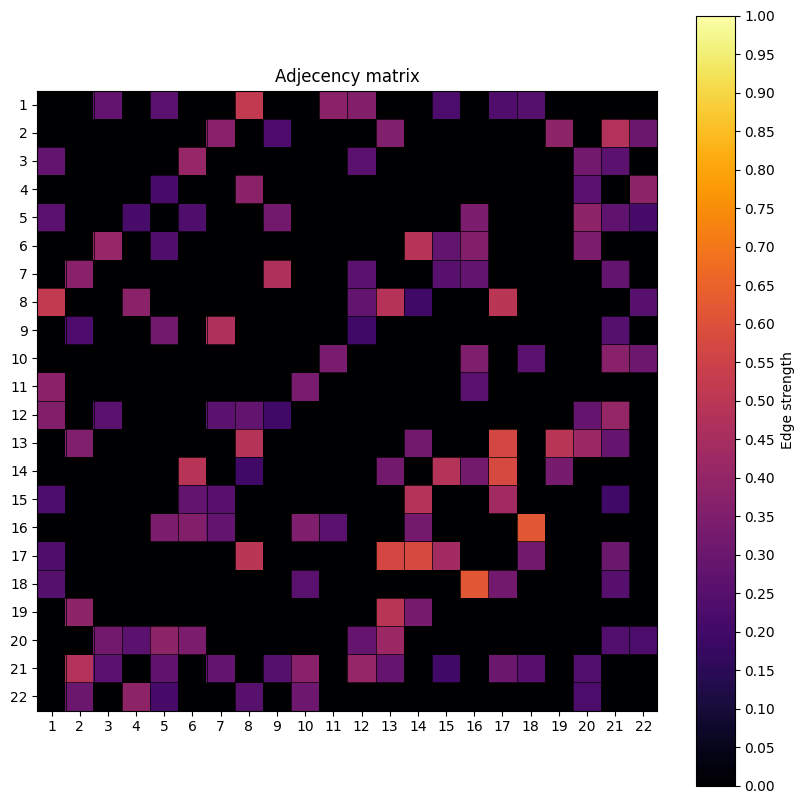

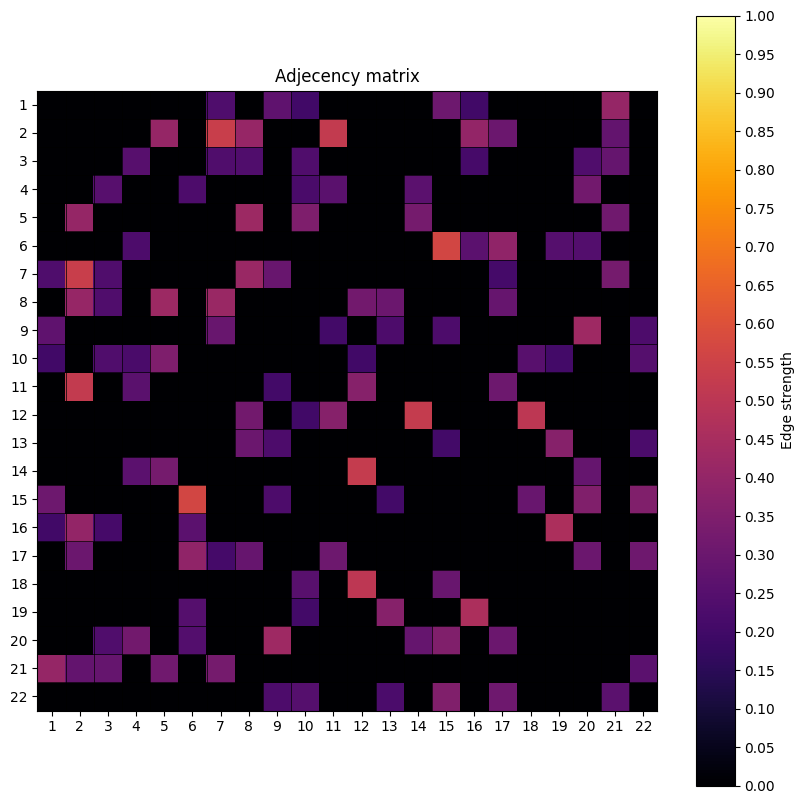

In [9]:
graphs=[]
adj_mats=[]
for i in range(modruns):
    adj_mats.append(mu.get_adj_mat(mods[i][0]))
    graphs.append(gu.make_graph(adj_mats[i]))
if plot:
    for adj in adj_mats:
        vu.visualize_adj_mat(adj)
#throw error if isomophic
for G1 in range(len(mods)):
    for G2 in range(G1+1,len(mods)):
        assert gu.check_not_isomorphism(graphs[G1],graphs[G2]), f"Graph G{G1} and G{G2} are isomophic"

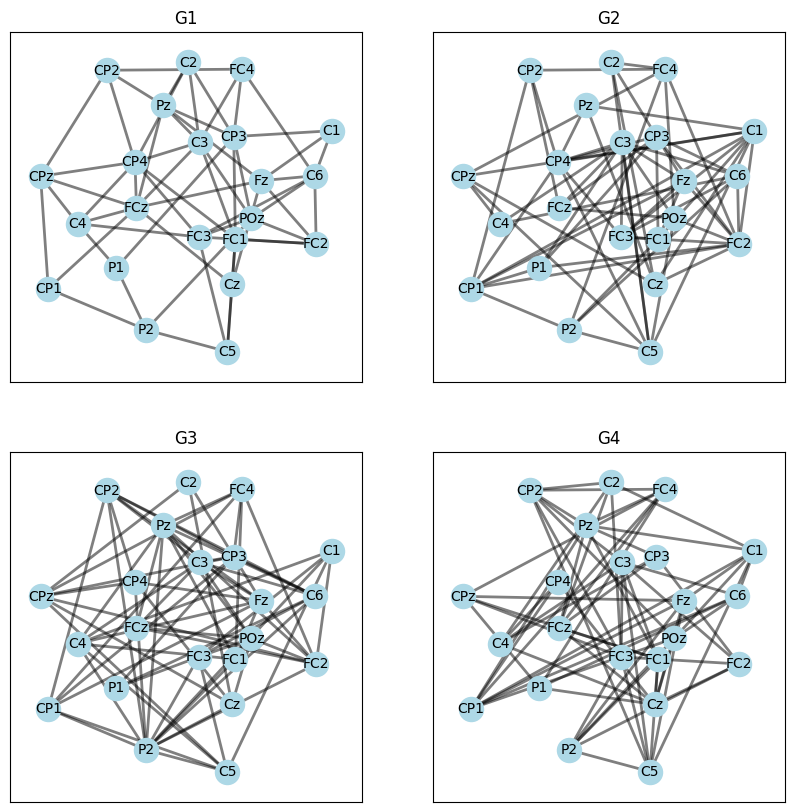

In [10]:
if plot:
    vu.graph_plot(adj_mats,vu.graph_visual,2,2)

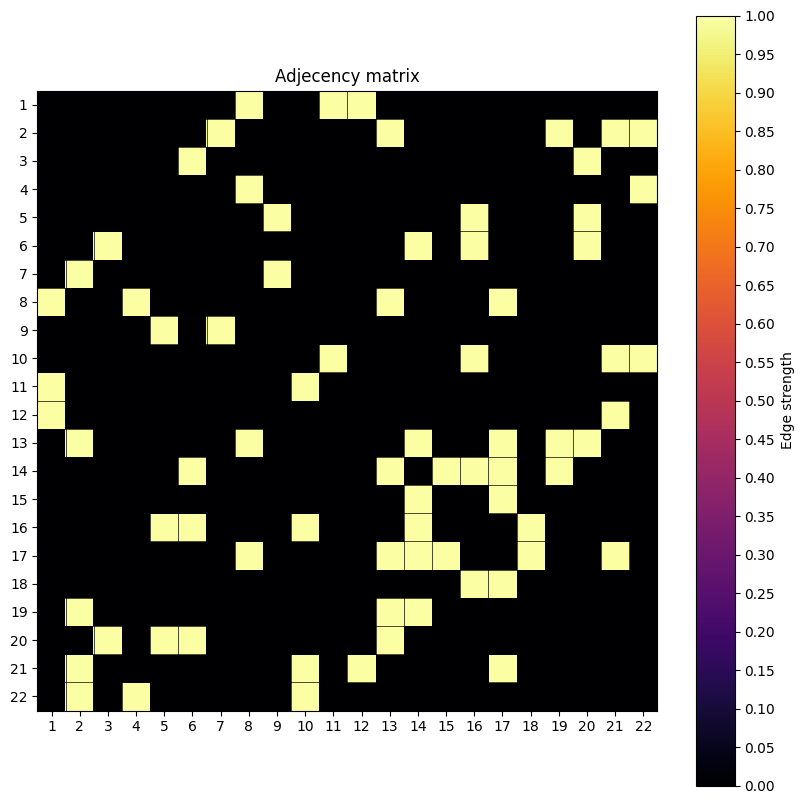

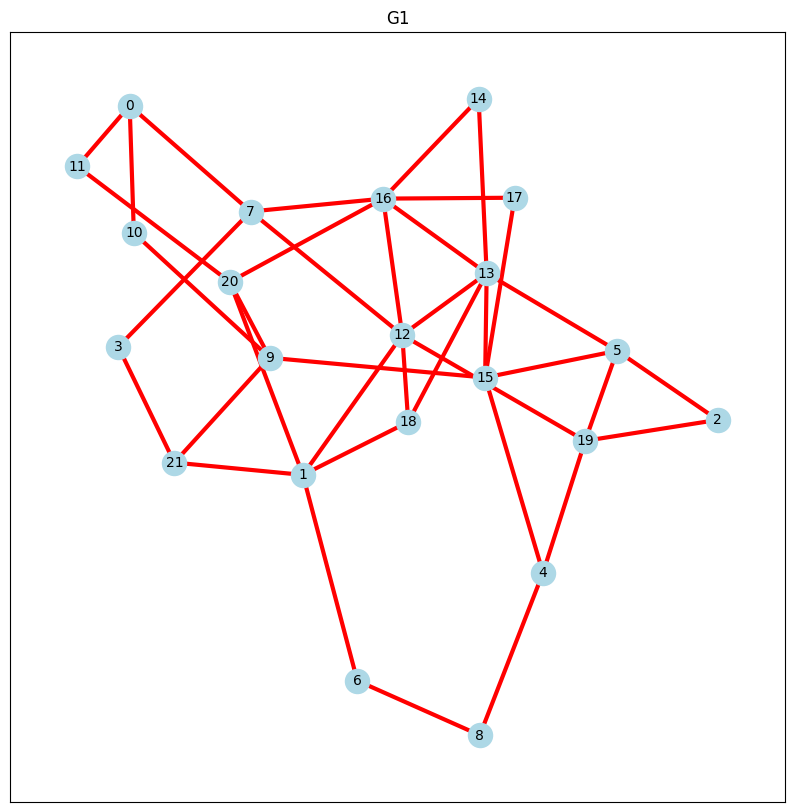

In [20]:
bi_g, bi_adj = gu.make_binary_graph(adj_mats[2],thresh=0.3)
if plot:
    vu.visualize_adj_mat(bi_adj)
    vu.graph_plot([bi_adj],vu.graph_visual,1,1)

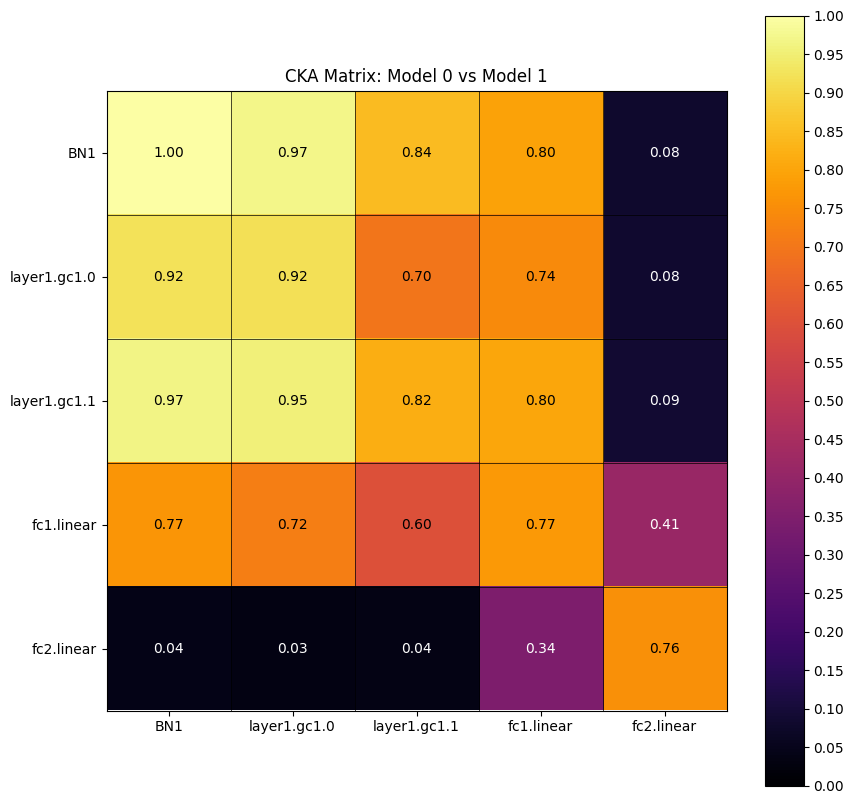

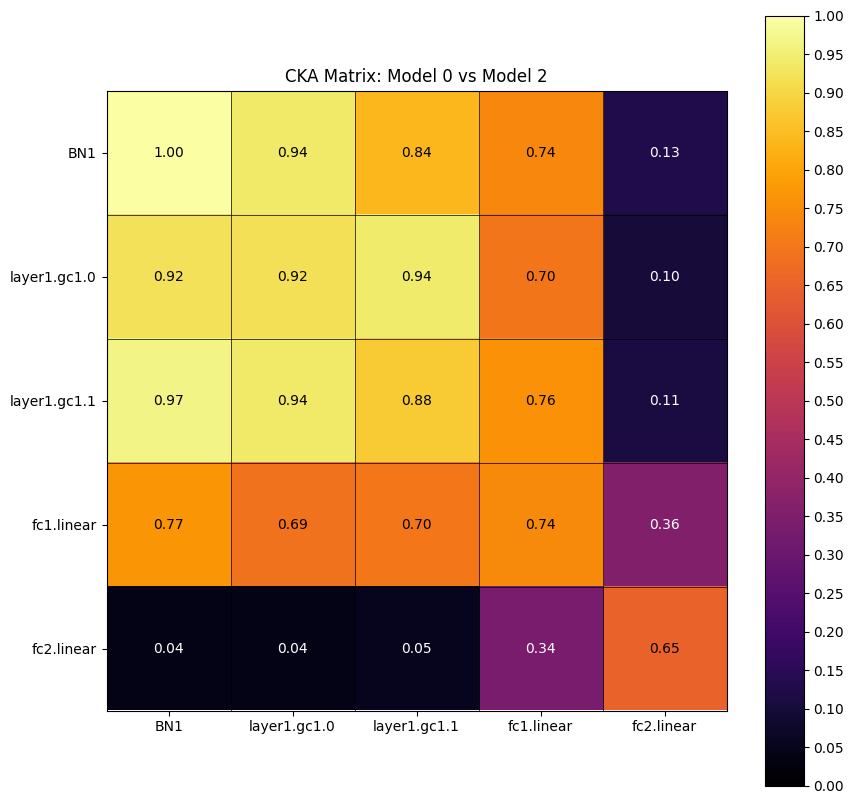

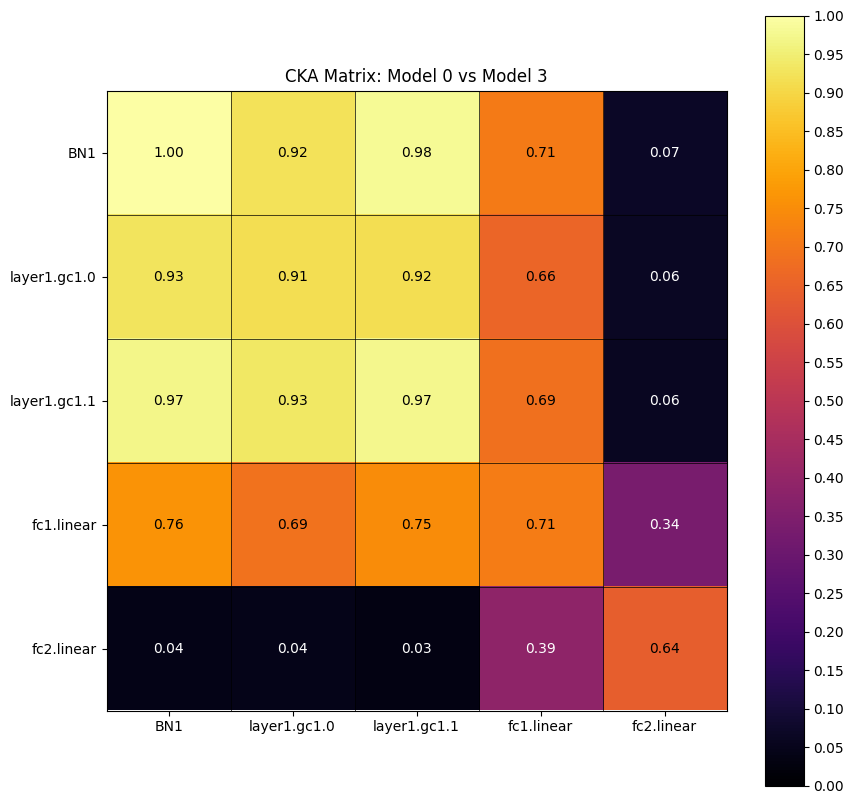

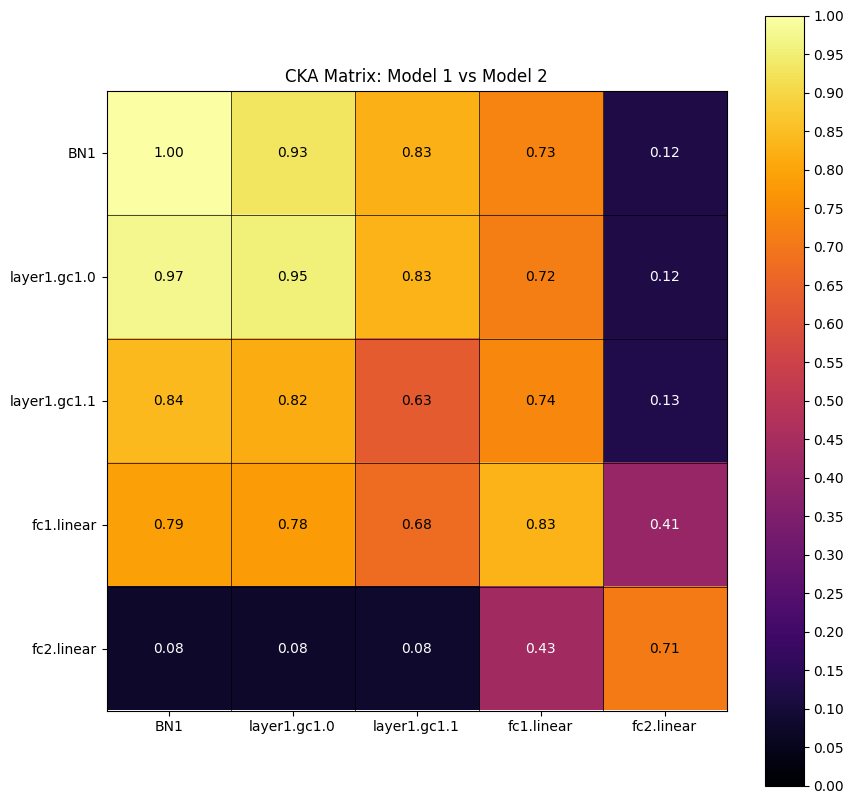

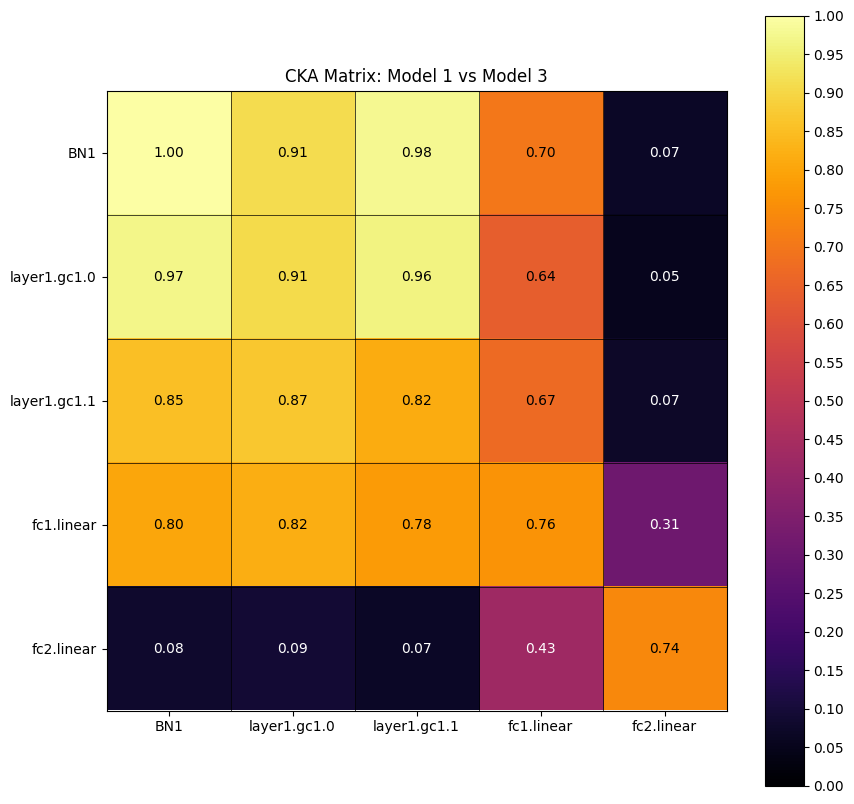

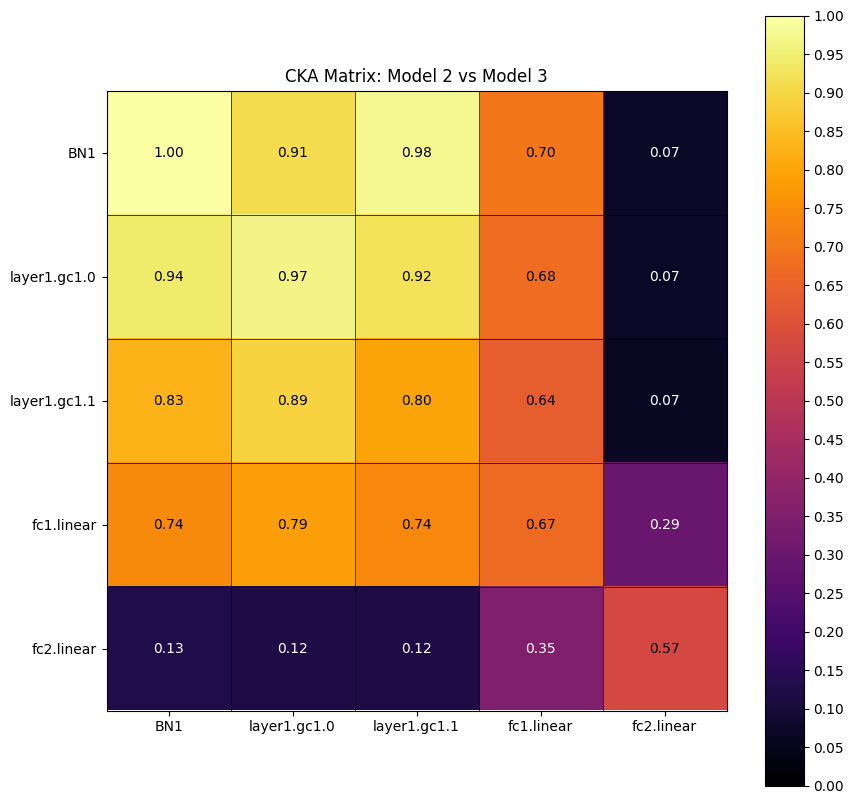

In [21]:
cka_all = []
for i in range(modruns-1):
    for j in range(i+1,modruns):
        calculator = CKACalculator(model1=mods[i][0], model2=mods[j][0], 
                                dataloader=train_loader,
                                layers_to_hook=(nn.Conv2d, nn.Linear,
                                     nn.AdaptiveAvgPool2d, GraphConvolution, nn.BatchNorm1d))
        cka_output = calculator.calculate_cka_matrix(train_dataset)
        #calculator.test_cka(10,train_dataset)
        cka_all.append(cka_output)
        if plot:
            vu.plot_matrix(f'CKA Matrix: Model {i} vs Model {j}'
                          ,cka_output.cpu().numpy(),calculator.module_names_X,
                           calculator.module_names_Y)

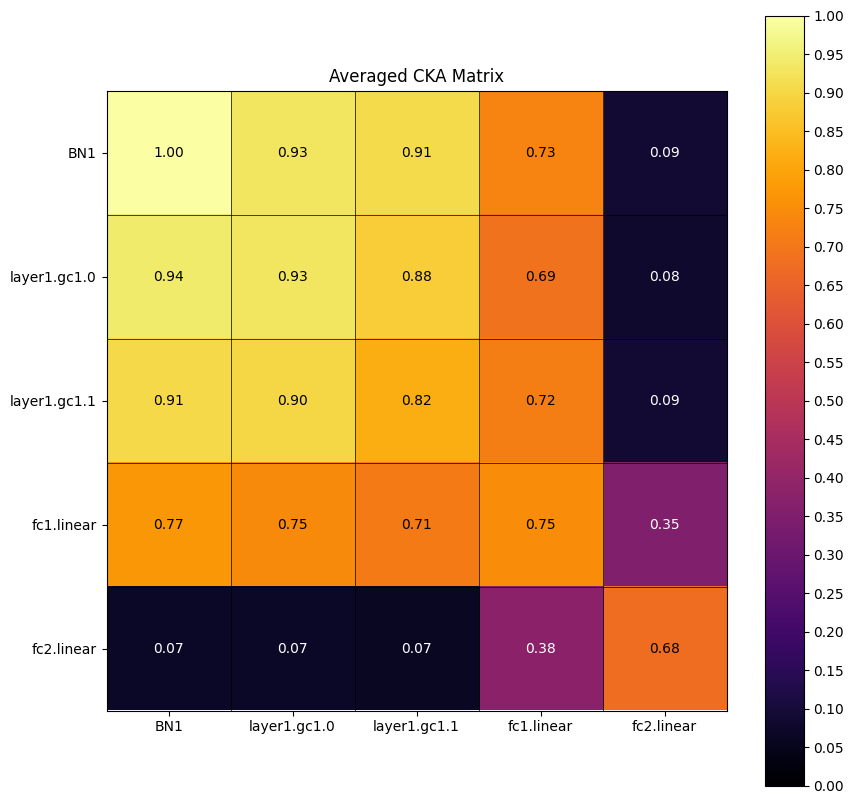

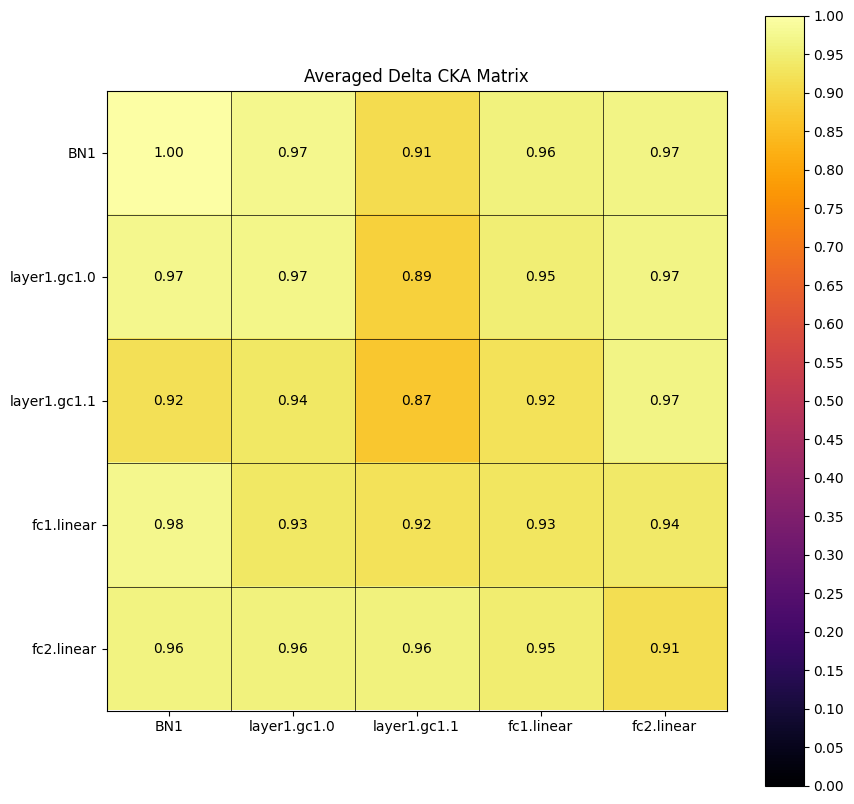

In [22]:
cka_stack = torch.stack(cka_all) 
average_cka_matrix = cka_stack.mean(dim=0)
delta_matrices = []

for i in range(len(cka_stack)):
    for j in range(i+1,len(cka_stack)):
        delta_matrices.append(torch.abs(cka_stack[i] - cka_stack[j])) 
        
delta_matrices = torch.stack(delta_matrices)  
average_delta_cka_matrix = 1- delta_matrices.mean(dim=0)  
if plot:
    vu.plot_matrix("Averaged CKA Matrix",average_cka_matrix.cpu().numpy(),calculator.module_names_X,calculator.module_names_Y)
    vu.plot_matrix("Averaged Delta CKA Matrix",average_delta_cka_matrix.cpu().numpy(),calculator.module_names_X,calculator.module_names_Y)

In [23]:
if has_val_set:

    for i  in range (len(mods)):
        filepath=f"{path}/Training_validation_loss{i}.npy"
        if not new_models:
            try: 
                with open(filepath, "rb") as f:
                    data = np.load(f)
            except:
                print(f"File with the data could not be found looking at address: {filepath}")
        else:
            with open(filepath, "wb") as f:
                np.save(f, mods[0][1])
                data = mods[0][1]
        plt.plot(data[0])
        plt.plot(data[1])
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend(["training loss","validation loss"])
        plt.title(f"Model{i} Training vs validation loss")
        plt.show()
    

In [31]:
node_labels = pd.read_csv("node_names.tsv", sep="\t")
node_labels = list(node_labels.iloc[:, 0])
node_labels

['Fz',
 'FC3',
 'FC1',
 'FCz',
 'FC2',
 'FC4',
 'C5',
 'C3',
 'C1',
 'Cz',
 'C2',
 'C4',
 'C6',
 'CP3',
 'CP1',
 'CPz',
 'CP2',
 'CP4',
 'P1',
 'Pz',
 'P2',
 'POz']